In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import struct

def read_idx(filename):
    '''A function to read idx file format into numpy array'''
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.fromstring(f.read(), dtype=np.uint8).reshape(shape)
    
train_set = read_idx('train-images-idx3-ubyte.mat')
train_set = np.expand_dims(train_set, axis=3)
print(train_set.shape)
train_label = read_idx('train-labels-idx1-ubyte.mat')
train_label = np.expand_dims(train_label, axis=1)
print(train_label.shape)

test_set = read_idx('t10k-images-idx3-ubyte.mat')
test_set = np.expand_dims(test_set, axis=3)
print(test_set.shape)
test_label = read_idx('t10k-labels-idx1-ubyte.mat')
test_label = np.expand_dims(test_label, axis=1)
print(test_label.shape)
n_train = train_set.shape[0]
n_test = test_set.shape[0]


(60000, 28, 28, 1)
(60000, 1)
(10000, 28, 28, 1)
(10000, 1)


C:\Users\User\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


In [2]:
def one_hot(labels):
    """
    Encodes the labels as one-hot vectors. Zero is represented as 10 in SVHN.
    [10] -> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    [2] -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
    
    """
    labels = np.squeeze(labels)
    one_hot_labels = []
    for num in labels:
        one_hot = [0.0] * 10
        if num == 10:
            one_hot[0] = 1.0
        else:
            one_hot[num] = 1.0
        one_hot_labels.append(one_hot)
    labels = np.array(one_hot_labels).astype(np.float32)
    return labels

train_label_one_hot = one_hot(train_label)
test_label_one_hot = one_hot(test_label)

print(train_label_one_hot.shape)
print(test_label_one_hot.shape)

(60000, 10)
(10000, 10)


In [4]:
class SVHN_CNN:
    def __init__(self, wd_factor, learning_rate): #initialize all the variable to be used in the other functions
        self.wd_factor = wd_factor
        self.learning_rate = learning_rate
        self.train_pointer = 0
        self.test_pointer = 0
        
        self.input = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28, 1], name='input') #to make a 28 times 28 minipatch swipe
        self.ground_truth = tf.placeholder(dtype=tf.float32, shape=[None, 10], name='ground_truth')
        
        # For batch norm and dropout
        self.is_training = tf.placeholder(tf.bool, name='is_training')
        print(self.input)
        
        self._build_graph()
        
    def _build_graph(self):
        weights = []  # for weight decay
        
        with tf.variable_scope('layers'):
            h = tf.layers.conv2d(self.input, 32, (11, 11), strides=(4, 4), padding='same', 
                                 data_format='channels_last', activation=None, use_bias=True,
                                 kernel_initializer=tf.glorot_uniform_initializer(), name='conv1')
            print(h)
            
            h = tf.layers.batch_normalization(h, training=self.is_training)
            h = tf.nn.relu(h)
            h = tf.layers.conv2d(h, 64, (5, 5), strides=(1, 1), padding='same', 
                                 data_format='channels_last', activation=None, use_bias=True,
                                 kernel_initializer=tf.glorot_uniform_initializer(), name='conv2')
            
            h = tf.layers.batch_normalization(h, training=self.is_training)
            h = tf.nn.relu(h)
            h = tf.layers.conv2d(h, 64, (3, 3), strides=(1, 1), padding='same', 
                                 data_format='channels_last', activation=None, use_bias=True,
                                 kernel_initializer=tf.glorot_uniform_initializer(), name='conv3')
            
            # Downsample
            h = tf.layers.max_pooling2d(h, (2, 2), (2, 2), padding='valid', name='pool1')
            print(h)
            
            # Fully connected layers
            h = tf.layers.batch_normalization(h, training=self.is_training)
            h = tf.nn.relu(h)
            h = tf.layers.flatten(h)
            print(h)
            
            h = tf.layers.dense(h, 32, kernel_initializer=tf.glorot_uniform_initializer(), 
                                activation=tf.nn.relu, name='dense1')
            print(h)
            h = tf.layers.dropout(h, rate=0.25, training=self.is_training, name='dropout1')
            print(h)
            
            self.logits = tf.layers.dense(h, 10, kernel_initializer=tf.glorot_uniform_initializer(), 
                                          activation=tf.identity, name='dense2')
            print(self.logits)
            self.prediction = tf.nn.softmax(self.logits, name='softmax_prediction')
            
        with tf.name_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, 
                                                                                  labels=self.ground_truth))
            self.loss += self.weight_decay()
            
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            self.train_op = self.optimizer.minimize(self.loss)
            
    def weight_decay(self):
        loss = 0
        for v in tf.global_variables():
            if 'Adam' in v.name:
                continue
            elif 'kernel' in v.name:
                loss += self.wd_factor * tf.nn.l2_loss(v)
        print(loss)
        return loss
    
    def train_minibatch(self, samples, labels, batch_size):
        if self.train_pointer + batch_size <= samples.shape[0]:
            samples_minibatch = samples[self.train_pointer: self.train_pointer + batch_size]
            labels_minibatch = labels[self.train_pointer: self.train_pointer + batch_size]
            self.train_pointer += batch_size
        else:
            samples_minibatch = samples[self.train_pointer:]
            labels_minibatch = labels[self.train_pointer:]
            self.train_pointer = 0
        return samples_minibatch, labels_minibatch

    def train(self, train_samples, train_labels, train_batch_size, iteration_steps):
        print('Start Training')
        losses = []
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            saver = tf.train.Saver()
            
            for i in range(iteration_steps):
                samples, labels = self.train_minibatch(train_samples, train_labels, train_batch_size)
                
                feed_dict = {self.input: samples, self.ground_truth: labels, self.is_training: True}
                _, loss = sess.run([self.train_op, self.loss], feed_dict=feed_dict)
                
                if i % 50 == 0:
                    print("Minibatch loss at step {}: {}".format(i, loss))
                    losses.append([i, loss])
                    
            saver.save(sess, './model')
        return losses
                    
    def test_minibatch(self, samples, labels, batch_size):
        if self.test_pointer + batch_size <= samples.shape[0]:
            samples_minibatch = samples[self.test_pointer: self.test_pointer + batch_size]
            labels_minibatch = labels[self.test_pointer: self.test_pointer + batch_size]
            self.test_pointer += batch_size
            end_of_epoch = False
        else:
            samples_minibatch = samples[self.test_pointer:]
            labels_minibatch = labels[self.test_pointer:]
            self.test_pointer = 0
            end_of_epoch = True
        return samples_minibatch, labels_minibatch, end_of_epoch
            
    def test(self, test_samples, test_labels, test_batch_size):
        self.test_pointer = 0
        end_of_epoch = False
        losses = []
        
        with tf.Session() as sess:
            saver = tf.train.import_meta_graph("./model.meta")
            saver.restore(sess, './model')
            while not end_of_epoch:
                samples, labels, end_of_epoch = self.test_minibatch(test_samples, test_labels, test_batch_size)
                feed_dict = {self.input: samples, self.ground_truth: labels, self.is_training: False}
                losses.append(sess.run(self.loss, feed_dict=feed_dict))  
        print("Average test loss: {}".format(np.mean(losses)))

In [5]:
WD_FACTOR = 0.0
LEARNING_RATE = 0.001
model = SVHN_CNN(WD_FACTOR, LEARNING_RATE)

Tensor("input:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("layers/conv1/BiasAdd:0", shape=(?, 7, 7, 32), dtype=float32)
Tensor("layers/pool1/MaxPool:0", shape=(?, 3, 3, 64), dtype=float32)
Tensor("layers/flatten/Reshape:0", shape=(?, 576), dtype=float32)
Tensor("layers/dense1/Relu:0", shape=(?, 32), dtype=float32)
Tensor("layers/dropout1/cond/Merge:0", shape=(?, 32), dtype=float32)
Tensor("layers/dense2/Identity:0", shape=(?, 10), dtype=float32)
Tensor("loss/add_4:0", shape=(), dtype=float32)


In [6]:
tf.global_variables()

[<tf.Variable 'layers/conv1/kernel:0' shape=(11, 11, 1, 32) dtype=float32_ref>,
 <tf.Variable 'layers/conv1/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'layers/batch_normalization/gamma:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'layers/batch_normalization/beta:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'layers/batch_normalization/moving_mean:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'layers/batch_normalization/moving_variance:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'layers/conv2/kernel:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'layers/conv2/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'layers/batch_normalization_1/gamma:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'layers/batch_normalization_1/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'layers/batch_normalization_1/moving_mean:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'layers/batch_normalization_1/moving_variance:0' shape=(64,) dtype=float32_ref>,
 <t

In [7]:
TRAIN_BATCH_SIZE = 128
ITERATIONS = 10000

import time
start_time = time.time()

losses = model.train(train_set, train_label_one_hot, TRAIN_BATCH_SIZE, ITERATIONS)

end_time = time.time()
print("Training time: {}s".format(end_time - start_time))

Start Training
Minibatch loss at step 0: 2.6473653316497803
Minibatch loss at step 50: 0.3927866518497467
Minibatch loss at step 100: 0.20497100055217743
Minibatch loss at step 150: 0.25017276406288147
Minibatch loss at step 200: 0.14867547154426575
Minibatch loss at step 250: 0.12555837631225586
Minibatch loss at step 300: 0.1212480291724205
Minibatch loss at step 350: 0.11226015537977219
Minibatch loss at step 400: 0.2839846909046173
Minibatch loss at step 450: 0.1882876753807068
Minibatch loss at step 500: 0.10382742434740067
Minibatch loss at step 550: 0.051527027040719986
Minibatch loss at step 600: 0.0773383155465126
Minibatch loss at step 650: 0.07667142897844315
Minibatch loss at step 700: 0.053534023463726044
Minibatch loss at step 750: 0.09142166376113892
Minibatch loss at step 800: 0.13618482649326324
Minibatch loss at step 850: 0.052924830466508865
Minibatch loss at step 900: 0.04233202710747719
Minibatch loss at step 950: 0.06006184220314026
Minibatch loss at step 1000: 0.

Minibatch loss at step 8300: 0.003739788895472884
Minibatch loss at step 8350: 0.01212353352457285
Minibatch loss at step 8400: 0.014489312656223774
Minibatch loss at step 8450: 0.008609862998127937
Minibatch loss at step 8500: 0.0016174113843590021
Minibatch loss at step 8550: 0.003483514068648219
Minibatch loss at step 8600: 0.004136069677770138
Minibatch loss at step 8650: 0.011587075889110565
Minibatch loss at step 8700: 0.003361356444656849
Minibatch loss at step 8750: 0.0079616978764534
Minibatch loss at step 8800: 0.00924171693623066
Minibatch loss at step 8850: 0.005935979075729847
Minibatch loss at step 8900: 0.001545205363072455
Minibatch loss at step 8950: 0.0022975292522460222
Minibatch loss at step 9000: 0.015901800245046616
Minibatch loss at step 9050: 0.0257068183273077
Minibatch loss at step 9100: 0.0009391727508045733
Minibatch loss at step 9150: 0.004651824943721294
Minibatch loss at step 9200: 0.01709110476076603
Minibatch loss at step 9250: 0.005801157560199499
Mini

In [14]:
try:
    losses = np.array(losses)
    np.save('./train_losses.npy', losses)
    print(losses.shape)
except NameError:
    losses = np.load('./train_losses.npy')

(200, 2)


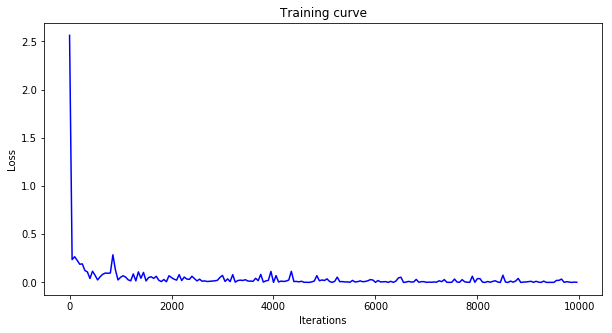

In [21]:
import matplotlib.pyplot as plt

iterations = losses[:, 0]
train_loss = losses[:, 1]

plt.figure(figsize=(10, 5))
plt.plot(iterations, train_loss, 'b-')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training curve")
plt.show()

In [23]:
TEST_BATCH_SIZE = 128

model.test(test_set, test_label_one_hot, TEST_BATCH_SIZE)

INFO:tensorflow:Restoring parameters from ./model
Average test loss: 0.04431871697306633


INFO:tensorflow:Restoring parameters from ./model
Test sample digit: 0


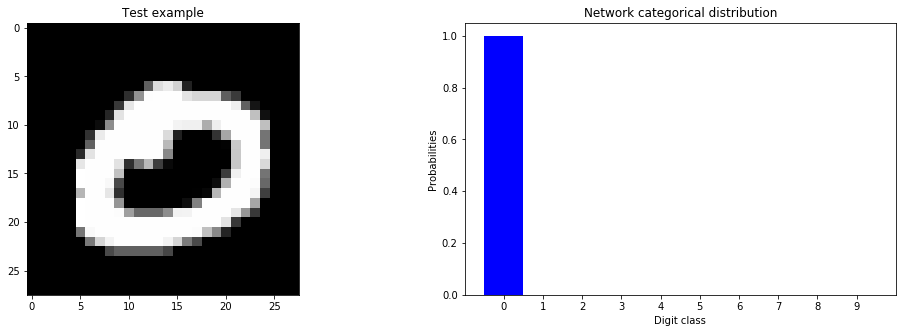

Network prediction probabilities:
[1.0000000e+00 4.1197924e-21 3.1334962e-18 5.2993878e-22 1.4845170e-20
 4.5447880e-22 1.0536494e-18 8.6437165e-17 1.6443058e-15 2.8721703e-17]


In [29]:
example = np.random.choice(np.arange(n_test))

sample = np.expand_dims(test_set[example], axis=0)
label = np.expand_dims(test_label_one_hot[example], axis=0)

digit = np.where(label[0]==1.0)[0][0]

feed_dict = {model.input: sample, model.ground_truth: label, model.is_training: False}

with tf.Session() as sess:
    saver = tf.train.import_meta_graph("./model.meta")
    saver.restore(sess, './model')
    prediction = sess.run(model.prediction, feed_dict=feed_dict)[0]

image = np.reshape(sample, (28, 28))

print("Test sample digit: {}".format(digit))
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Test example")

classes = np.arange(10)
width = 1.0

#fig, ax = plt.subplots()
ax[1].bar(classes, prediction, width, color='Blue')
ax[1].set_ylabel('Probabilities')
ax[1].set_title('Network categorical distribution')
ax[1].set_xticks(classes)
ax[1].set_xticklabels(('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'))
ax[1].set_xlabel('Digit class')

plt.show()

print("Network prediction probabilities:")
print(prediction)

In [31]:
train_time = end_time - start_time
print('total training time :', train_time, 's, or ', int(train_time/60), 'min', train_time%60, 's' )
count = len(tf.global_variables())
print('total parameters involved :', count)

total training time : 1356.0372931957245 s, or  22 min 36.03729319572449 s
total parameters involved : 392
